### 1. Import necessary libraries

In [1]:
import os
import time
import math
import warnings
import random
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import DataLoader, sampler, random_split, TensorDataset
import timm

# turn off warnings
warnings.filterwarnings("ignore")
# set environment to solve the conflict between pytorch and matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 2. Configure PyTorch environment

In [2]:
# define the configuration of pytorch
gpu_index = torch.randint(0, torch.cuda.device_count(), (1,)).item()
dtype = torch.float
device = torch.device('cuda:{}'.format(gpu_index))
print("PyTorch is using GPU {}!".format(device))

PyTorch is using GPU cuda:0!


In [3]:
# define a function that returns a consistent, predetermined random number
def fix_random_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 3. Bin price target into 8 categories for classification task

In [4]:
# read the guitar info
df = pd.read_csv("guitar_info.csv")

# load the valid guitar image indice
train_data_id = []
file_path = "guitar_resized_images"

# walk through all resized guitar images
for root, dirs, files in os.walk(file_path):
    for file in files:
        train_data_id.append(int(file.replace(".png","")))
        
# select the guitar info of resized images
df = df[df['index'].isin(train_data_id)]
df['price'] = df['price'].apply(lambda x:math.ceil(float(x.replace("$","").replace(",",""))))

# remove 36 outliers that have exorbitant price 
df = df[df['price']<5000]

# split the price into 8 different ranges
num_bins = 8
bins = [0, 200, 400, 600, 800, 1100, 1500, 2200, 5000]
labels = [f'Price_Bin_{i+1}' for i in range(num_bins)]

# perform the quantile binning
df['price_bin'] = pd.cut(df['price'], bins = bins, labels=labels, right=True, include_lowest=True)

# concatenate the price bins
df = pd.concat([df,pd.get_dummies(df['price_bin'])],axis=1)

# display the price interval
for label, lower_bound, upper_bound in zip(labels, bins[:-1], bins[1:]):
    print(f"{label}: ({lower_bound:.0f}, {upper_bound:.0f}]")
    
# add the path of images to dataframe
df['path'] = df['index'].apply(lambda x:'guitar_resized_images/000000'+ str(x) + '.png')

Price_Bin_1: (0, 200]
Price_Bin_2: (200, 400]
Price_Bin_3: (400, 600]
Price_Bin_4: (600, 800]
Price_Bin_5: (800, 1100]
Price_Bin_6: (1100, 1500]
Price_Bin_7: (1500, 2200]
Price_Bin_8: (2200, 5000]


### 4. Process numerical and categorical features

In [5]:
# include additional guitar information: brand, condition and selling location
# extract the brand of guitar from the title
df['brand'] = df['title'].apply(lambda x: " ".join(x.split(" ")[1:]))
df['brand'] = df['brand'].apply(lambda x: x.replace("Used ","").split(" ")[0])
df_brand = df['brand'].value_counts().reset_index()
main_brand = list(df_brand[df_brand['brand']>5]['index'])
df['brand'] = df['brand'].apply(lambda x: x if x in main_brand else 'Other')

# extract the state from the 'location' column
df['location'] = df['location'].apply(lambda x: x.split(",")[1])

# convert guitar condition categories to ordinal numbers reflecting their quality
condition_mapping = {'Poor': 0,'Fair': 1,'Good': 2,'Great': 3,'Excellent': 4}
df['condition'] = df['condition'].map(condition_mapping)

# concatenate all one-hot encoded features
df_brand = pd.get_dummies(df['brand'], prefix='brand')
feature1 = df_brand.columns
df_location = pd.get_dummies(df['location'], prefix='location')
feature2 = df_location.columns
df = pd.concat([df, df_brand,df_location], axis=1)

# determine the feature for tabular data
tabular_features = list(feature1).copy()
tabular_features.extend(list(feature2))
tabular_features.extend(["condition"])

### 5. Augment images and prepare datasets

In [6]:
# define a class to generate training, validation, and testing set
class Guitar_Image_Data_Set:
    """ this class is designed to generate training, validation, and testing set from guitar images"""
    def __init__(self, dataframe, transform):
        self.df = dataframe
        self.tf = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        # retrieve the image based on the file path
        path_idx = self.df['path'].iloc[idx]

        # apply the transformation to images
        image = Image.open(path_idx)
        transform = self.tf
        image = transform(image)
        image = image.to(device=device, dtype=dtype)
        
        # convert the tabular data to torch.tensor
        tabular = torch.tensor(self.df[tabular_features].iloc[idx], device=device, dtype=dtype)

        # convert price from dataframe to torch.tensor
        price = torch.tensor(self.df[labels].iloc[idx], device=device, dtype=dtype)
        price = price.to(device=device, dtype=dtype)

        return image, tabular, price
    
    
# define a function to calculate the mean and std of RGB channels for groups of images
def normal_para(df, transformer):
    tensors = []
    # walk through all images and convert them to tensors
    for path in df['path'].values:
        image = Image.open(path)
        tensor = transformer(image)
        tensors.append(tensor)

    # stack all tensors into a single tensor
    tensor_stack = torch.stack(tensors, dim=0)

    # calculate the mean and std
    mean = torch.mean(tensor_stack, dim=[0, 2, 3])
    std = torch.std(tensor_stack, dim=[0, 2, 3])
    
    return mean,std

# define a function to extract small number of batches.
def subset_of_dataloader(dataloader, num_batches):
    subset_data = []
    for i, data in enumerate(dataloader):
        subset_data.append(data)
        if i + 1 == num_batches:
            break
    return subset_data

In [7]:
# define a tensor transformer
image_transformer = T.ToTensor()

# calculate the mean and std of RGB channels for different types of images
mean, std = normal_para(df, image_transformer)

In [8]:
# create transformors to normalize images
fix_random_seed()
transform = T.Compose([T.RandomRotation(degrees=(-15, 15)), # randomly rotate images to increase data diversity
                       T.RandomHorizontalFlip(),  # randomly flip images to further increase data diversity
                       T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.3), # randomly color jitter images to increase data diversity
                       T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # randomly affline images to increase data diversity
                       T.RandomPerspective(distortion_scale=0.2, p=0.3),  # randomly change the perspective of images to increase data diversity
                       T.ToTensor(),
                       T.Normalize(mean, std) 
])

# create an instance of the Dataset
guitar_dataset = Guitar_Image_Data_Set(dataframe = df,transform = transform)

In [9]:
# create training, validation, and testing data set
fix_random_seed()

# define the ratio for training, validation, and testing set
total = len(guitar_dataset)
train = 0.7
validation = 0.15

# split the whole dataset into training, validation, and testing set
train_size = int(train * total)
validation_size = int(validation * total)
test_size = total - train_size - validation_size
train_dataset, validation_dataset, test_dataset = random_split(guitar_dataset, [train_size, validation_size, test_size])

loader_train = DataLoader(train_dataset, batch_size = 32,shuffle = True)
loader_val = DataLoader(validation_dataset, batch_size = 32,shuffle = True)
loader_test = DataLoader(test_dataset, batch_size = 32,shuffle = True)
# extract small number of batches from training set to determine the model architecture, learning rate, etc
loader_small = subset_of_dataloader(loader_train, 10)

### 6. Train ensemble models based on pre-trained image and tabular data models

In [10]:
# define the ensemble model class to integrate the image, condition, and location of guitars
class EnsembleModel(nn.Module):
    def __init__(self, image_model, tabular_model, final_model):
        super(EnsembleModel, self).__init__()
        
        self.image_model = image_model
        self.tabular_model = tabular_model
        self.final_model = final_model

        for param in self.image_model.parameters():
            param.requires_grad = False
        
        for param in self.tabular_model.parameters():
            param.requires_grad = False 
        
        
    def forward(self, images, tabular):
        img_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular)
        combined = torch.cat((img_features, tabular_features), dim=1)
        price = self.final_model(combined)
        return price

    def to(self, device):
        super().to(device)
        self.image_model = self.image_model.to(device)
        self.tabular_model = self.tabular_model.to(device)
        self.final_model = self.final_model.to(device)
        return self

In [11]:
# define a function for adjusting learning rate
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
    """
    Multiply lrd to the learning rate if epoch is in schedule

    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - lrd: learning rate decay; a factor multiplied at scheduled epochs
    - epochs: the current epoch number
    - schedule: the list of epochs that requires learning rate update

    Returns: Nothing, but learning rate might be updated
    """
    if epoch in schedule:
        for param_group in optimizer.param_groups:
            print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
            param_group['lr'] *= lrd


# define a function to initialize the weight
def initialize_weight(m, init_type):
    if isinstance(m, nn.Linear):
        if init_type == 'kaiming':
            init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        elif init_type == 'xavier':
            init.xavier_uniform_(m.weight)
        elif init_type == 'uniform':
            init.uniform_(m.weight, a=-0.1, b=0.1)
        if m.bias is not None:
            init.zeros_(m.bias)          
            

# define a function for training the model
def train_model(model, optimizer, dataset, epochs=1, learning_rate_decay=.1, schedule=[], criterion = nn.CrossEntropyLoss(), print_every = 100, validate = True):
    """
    Train a model on guitar image dataset using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
     # define a list to record the model performance in each iteration
    train_acc = []
    val_acc = []
    result = []
    num_iters = epochs * len(dataset)
    num_prints = num_iters // print_every + 1

    for e in range(epochs):
        
        adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

        for t, (images, tabulars, prices) in enumerate(dataset):
            # put model to training mode
            model.train()
            # move data to the appropriate device
            images = images.to(device)
            tabulars = tabulars.to(device)
            prices = prices.to(device)
            
            outputs = model(images, tabulars)
            
            # calculatet the loss using assigned criterion 
            loss = criterion(outputs, prices)
            
            # zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # this is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            result.append((e+1,t+1,loss.item()))
            
            if validate and t % print_every == 0:
                _, accuracy, _, _, _ = evaluate_model(model, dataset, 10)
                val_loss, val_accuracy, _, _, _ = evaluate_model(model, loader_val, 10)
                train_acc.append((e + 1, accuracy))
                val_acc.append((e + 1, val_accuracy))
                print('Epoch %d, Iteration %d, loss = %.4f, val_loss = %.4f, accuracy = %.4f, val_accuracy = %.4f' % (e, t, loss.item(), val_loss, accuracy, val_accuracy))
            elif not validate and t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

    return train_acc, val_acc, result


# define a function to evaluate the model performance
def evaluate_model(model, dataset, num_classes):
    model.to(device).eval()  # Move model to device and set to evaluation mode
    criterion = torch.nn.CrossEntropyLoss()  # Assuming you're using CrossEntropyLoss

    accuracy = torchmetrics.Accuracy(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    precision = torchmetrics.Precision(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    recall = torchmetrics.Recall(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    f1 = torchmetrics.F1Score(average='weighted', num_classes=num_classes, task='multiclass').to(device)

    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for images, tabulars, prices in dataset:
            prices = torch.argmax(prices, dim=1) 
            images = images.to(device=device)
            tabulars = tabulars.to(device=device)
            prices = prices.to(device=device)

            outputs = model(images, tabulars)
            loss = criterion(outputs, prices)
            total_loss += loss.item() * prices.size(0)
            total_count += prices.size(0)

            _, predicted = torch.max(outputs, 1)
            accuracy.update(predicted, prices)
            precision.update(predicted, prices)
            recall.update(predicted, prices)
            f1.update(predicted, prices)

    # Compute final metrics
    final_loss = total_loss / total_count
    final_accuracy = accuracy.compute()
    final_precision = precision.compute()
    final_recall = recall.compute()
    final_f1 = f1.compute()
    
    return final_loss, final_accuracy.item(), final_precision.item(), final_recall.item(), final_f1.item()


# define a function to visualize the accuracy in the training process
def plot_accuracy(train,val):
    df_train = pd.DataFrame(train,columns = ['epoch','accuracy'])
    df_val = pd.DataFrame(val,columns = ['epoch','accuracy'])
    sns.lineplot(data = df_train, x = 'epoch', y = 'accuracy',c ='blue',linewidth = 4 ,label = 'train')
    sns.lineplot(data = df_val, x = 'epoch', y = 'accuracy',c ='red',linewidth = 4 ,label = 'validation')
    plt.show()


# define a function to visualize the training loss
def plot_loss(result):
    df_train = pd.DataFrame(result,columns = ['epoch','iteration','loss'])
    df_avg = df_train.groupby('epoch').mean()['loss'].reset_index()
    sns.scatterplot(data = df_train, x = 'epoch', y = 'loss')
    sns.lineplot(data = df_avg, x = 'epoch', y = 'loss',c = '#3EBCBE', linewidth = 4)
    plt.show()    

#### (1). Train an Ensemble Model Combining Pre-trained ResNet and Tabular ANN

Epoch 0, Iteration 0, loss = 2.5947, val_loss = 2.2049, accuracy = 0.1742, val_accuracy = 0.1619
Epoch 1, Iteration 0, loss = 2.2760, val_loss = 1.9330, accuracy = 0.2682, val_accuracy = 0.2639
Epoch 2, Iteration 0, loss = 2.2393, val_loss = 1.8699, accuracy = 0.3208, val_accuracy = 0.3193
Epoch 3, Iteration 0, loss = 1.9388, val_loss = 1.8238, accuracy = 0.3617, val_accuracy = 0.3326
Epoch 4, Iteration 0, loss = 1.8039, val_loss = 1.7884, accuracy = 0.3953, val_accuracy = 0.3304
Epoch 5, Iteration 0, loss = 2.1532, val_loss = 1.7621, accuracy = 0.3806, val_accuracy = 0.3459
Epoch 6, Iteration 0, loss = 1.7422, val_loss = 1.7574, accuracy = 0.4139, val_accuracy = 0.3392
Epoch 7, Iteration 0, loss = 1.5131, val_loss = 1.7458, accuracy = 0.4314, val_accuracy = 0.3437
Epoch 8, Iteration 0, loss = 2.0852, val_loss = 1.7512, accuracy = 0.4352, val_accuracy = 0.3126
Epoch 9, Iteration 0, loss = 1.7754, val_loss = 1.6975, accuracy = 0.4271, val_accuracy = 0.3503
lr decay from 2e-05 to 6e-06
E

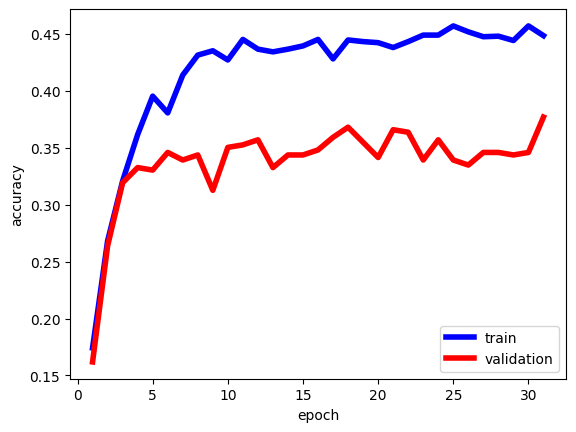

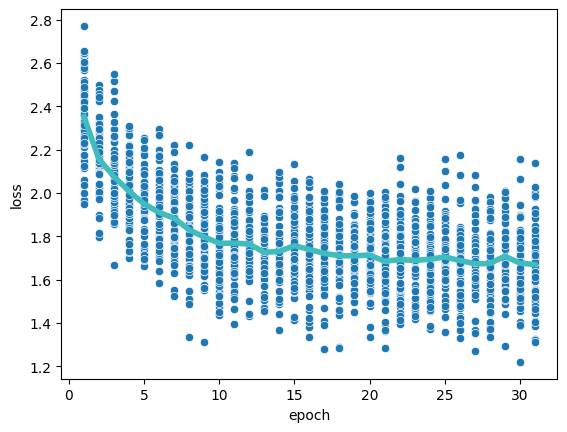

The Ensemble Model Performance for ResNet + Tabular ANN:
Testing - Loss: 1.6696, Accuracy: 0.3473, Precision: 0.3409, Recall: 0.3473, F1 Score: 0.2990


In [12]:
fix_random_seed()

# Load the image model
with open('resnet_model.pkl', 'rb') as f:
    image_model = pickle.load(f)

image_model.fc[3] = nn.Identity()
image_model.to(device)

# load the tabular model
with open('tabular_model.pkl', 'rb') as f:
    tabular_model = pickle.load(f)

tabular_model[9] = nn.Identity()
tabular_model.to(device)

# create the final model
final_model = nn.Sequential(
              nn.Linear(1152, 1024),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(1024, 8))
final_model.to(device)

# create the ensemble model
ensemble_model = EnsembleModel(image_model = image_model,
                      tabular_model = tabular_model,
                      final_model = final_model)

# set up the hyperparameters
learning_rate = 2e-5
learning_rate_schedule = [10, 20, 30, 40]
weight_decay = 5e-6
epochs = 31 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
ensemble_model.apply(lambda m: initialize_weight(m, init_type='kaiming'))
ensemble_model.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(ensemble_model.parameters(), 
                       lr = learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = ensemble_model, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.3,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(ensemble_model, loader_test, num_classes = 8)
print("The Ensemble Model Performance for ResNet + Tabular ANN:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [13]:
# Save the ResNet Ensemble model
with open('resnet_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

#### (2). Train an Ensemble Model Combining Pre-trained SqueezeNet and Tabular ANN

Epoch 0, Iteration 0, loss = 14.0910, val_loss = 8.2599, accuracy = 0.0812, val_accuracy = 0.0798
Epoch 1, Iteration 0, loss = 7.7541, val_loss = 3.1265, accuracy = 0.0963, val_accuracy = 0.1220
Epoch 2, Iteration 0, loss = 8.8193, val_loss = 2.7178, accuracy = 0.1870, val_accuracy = 0.2151
Epoch 3, Iteration 0, loss = 5.9815, val_loss = 2.5298, accuracy = 0.2027, val_accuracy = 0.2195
Epoch 4, Iteration 0, loss = 6.4398, val_loss = 2.4704, accuracy = 0.2207, val_accuracy = 0.2306
Epoch 5, Iteration 0, loss = 5.8724, val_loss = 2.5156, accuracy = 0.2368, val_accuracy = 0.2705
Epoch 6, Iteration 0, loss = 5.9483, val_loss = 2.2891, accuracy = 0.2549, val_accuracy = 0.2417
Epoch 7, Iteration 0, loss = 5.2291, val_loss = 2.2955, accuracy = 0.2805, val_accuracy = 0.2860
Epoch 8, Iteration 0, loss = 5.2636, val_loss = 2.2443, accuracy = 0.2867, val_accuracy = 0.2727
Epoch 9, Iteration 0, loss = 4.9471, val_loss = 2.2230, accuracy = 0.2881, val_accuracy = 0.2794
lr decay from 1e-05 to 3e-06


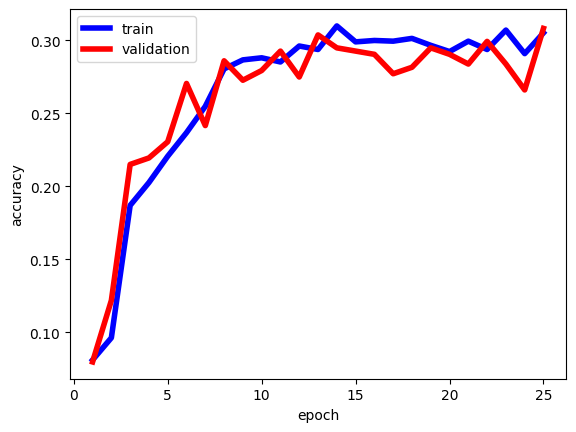

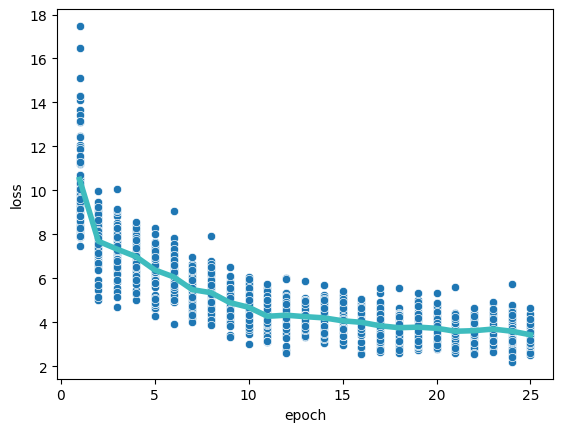

The Model Performance for SqueezeNet + Tabular ANN:
Testing - Loss: 2.1840, Accuracy: 0.2699, Precision: 0.2193, Recall: 0.2699, F1 Score: 0.2212


In [14]:
#### fix_random_seed()

# define the forward method directly for SqueezeNet image model
def custom_forward(x):
    x = image_model.features(x)
    x = image_model.classifier(x)
    return x.view(x.size(0), 512)

# Load the image model
with open('squeezenet_model.pkl', 'rb') as f:
    image_model = pickle.load(f)

image_model.classifier[1] = nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
image_model.forward = custom_forward
image_model.to(device)

# load the tabular model
with open('tabular_model.pkl', 'rb') as f:
    tabular_model = pickle.load(f)

tabular_model[9] = nn.Identity()
tabular_model.to(device)

# create the final model
final_model = nn.Sequential(
              nn.Linear(640, 512),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(512, 8))
final_model.to(device)

# create the ensemble model
ensemble_model = EnsembleModel(image_model = image_model,
                      tabular_model = tabular_model,
                      final_model = final_model)

# set up the hyperparameters
learning_rate = 1e-5
learning_rate_schedule = [10, 20, 30, 40]
weight_decay = 2e-6
epochs = 25 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
ensemble_model.apply(lambda m: initialize_weight(m, init_type='kaiming'))
ensemble_model.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(ensemble_model.parameters(), 
                       lr = learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = ensemble_model, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.3,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(ensemble_model, loader_test, num_classes = 8)
print("The Model Performance for SqueezeNet + Tabular ANN:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [15]:
# Save the SqueezeNet Ensemble model
with open('squeezenet_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

#### (3). Train an Ensemble Model Combining Pre-trained DenseNet and Tabular ANN

Epoch 0, Iteration 0, loss = 2.9881, val_loss = 2.2206, accuracy = 0.1177, val_accuracy = 0.1375
Epoch 1, Iteration 0, loss = 2.5883, val_loss = 1.9023, accuracy = 0.2990, val_accuracy = 0.2661
Epoch 2, Iteration 0, loss = 2.4388, val_loss = 1.7651, accuracy = 0.4044, val_accuracy = 0.3570
Epoch 3, Iteration 0, loss = 2.2024, val_loss = 1.7105, accuracy = 0.4756, val_accuracy = 0.3392
Epoch 4, Iteration 0, loss = 2.0881, val_loss = 1.7004, accuracy = 0.5202, val_accuracy = 0.3769
Epoch 5, Iteration 0, loss = 1.7376, val_loss = 1.5940, accuracy = 0.5610, val_accuracy = 0.3969
Epoch 6, Iteration 0, loss = 1.8313, val_loss = 1.5765, accuracy = 0.5691, val_accuracy = 0.4191
Epoch 7, Iteration 0, loss = 1.3903, val_loss = 1.5609, accuracy = 0.5904, val_accuracy = 0.4035
Epoch 8, Iteration 0, loss = 1.8577, val_loss = 1.5801, accuracy = 0.5928, val_accuracy = 0.4102
Epoch 9, Iteration 0, loss = 1.4254, val_loss = 1.5528, accuracy = 0.6051, val_accuracy = 0.4279
lr decay from 2e-05 to 6e-06
E

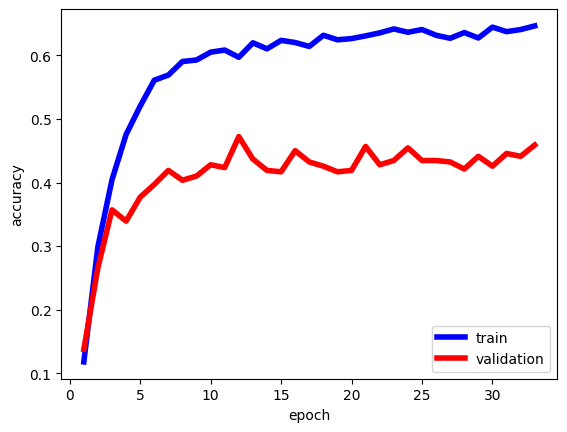

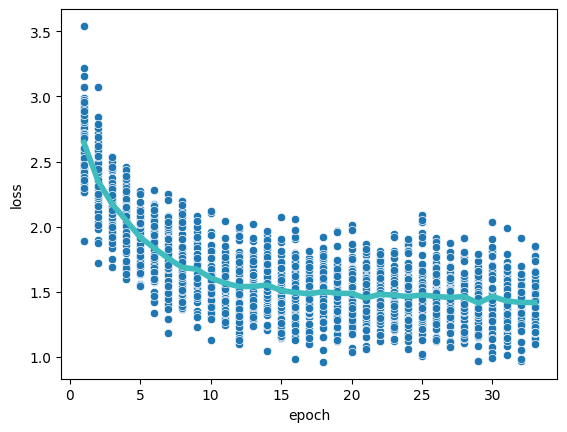

The Model Performance for DenseNet + Tabular ANN:
Testing - Loss: 1.5870, Accuracy: 0.4226, Precision: 0.4135, Recall: 0.4226, F1 Score: 0.3981


In [16]:
fix_random_seed()

# Load the image model
with open('densenet_model.pkl', 'rb') as f:
    image_model = pickle.load(f)

image_model.classifier[3] = nn.Identity()
image_model.to(device)

# load the tabular model
with open('tabular_model.pkl', 'rb') as f:
    tabular_model = pickle.load(f)

tabular_model[9] = nn.Identity()
tabular_model.to(device)

# create the final model
final_model = nn.Sequential(
              nn.Linear(1152, 1024),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(1024, 8))
final_model.to(device)

# create the ensemble model
ensemble_model = EnsembleModel(image_model = image_model,
                      tabular_model = tabular_model,
                      final_model = final_model)

# set up the hyperparameters
learning_rate = 2e-5
learning_rate_schedule = [10, 20, 30, 40]
weight_decay = 5e-6
epochs = 33 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
ensemble_model.apply(lambda m: initialize_weight(m, init_type='kaiming'))
ensemble_model.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(ensemble_model.parameters(), 
                       lr = learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = ensemble_model, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.3,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(ensemble_model, loader_test, num_classes = 8)
print("The Model Performance for DenseNet + Tabular ANN:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [17]:
# Save the DenseNet Ensemble model
with open('densenet_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

#### (4). Train an Ensemble Model Combining Pre-trained VGG16 and Tabular ANN

Epoch 0, Iteration 0, loss = 2.2148, val_loss = 2.1243, accuracy = 0.1025, val_accuracy = 0.1020
Epoch 1, Iteration 0, loss = 2.2305, val_loss = 2.0160, accuracy = 0.2430, val_accuracy = 0.2528
Epoch 2, Iteration 0, loss = 2.1299, val_loss = 1.9827, accuracy = 0.2458, val_accuracy = 0.2528
Epoch 3, Iteration 0, loss = 2.0072, val_loss = 1.9536, accuracy = 0.2563, val_accuracy = 0.2594
Epoch 4, Iteration 0, loss = 1.7790, val_loss = 1.9385, accuracy = 0.2549, val_accuracy = 0.2616
Epoch 5, Iteration 0, loss = 1.9376, val_loss = 1.9148, accuracy = 0.2682, val_accuracy = 0.2639
Epoch 6, Iteration 0, loss = 1.9620, val_loss = 1.8998, accuracy = 0.2819, val_accuracy = 0.2727
Epoch 7, Iteration 0, loss = 1.8125, val_loss = 1.8972, accuracy = 0.2919, val_accuracy = 0.2639
Epoch 8, Iteration 0, loss = 2.1296, val_loss = 1.8924, accuracy = 0.2995, val_accuracy = 0.2860
Epoch 9, Iteration 0, loss = 1.9931, val_loss = 1.8644, accuracy = 0.3004, val_accuracy = 0.3016
lr decay from 1e-05 to 3e-06
E

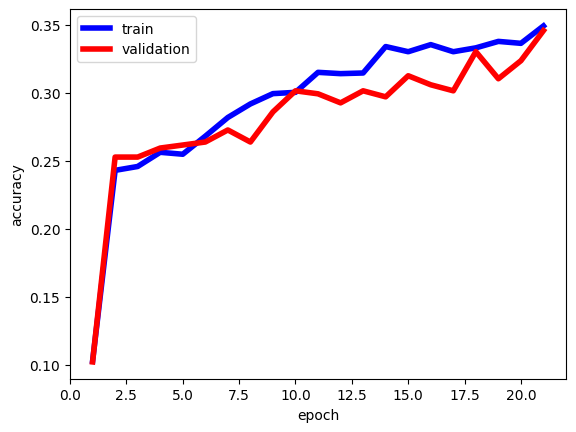

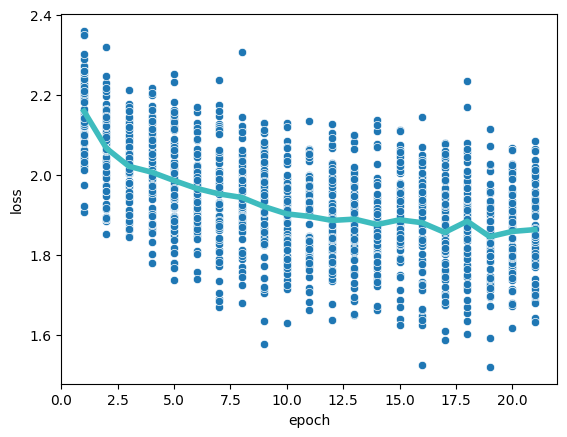

The Model Performance for VGG16 + Tabular ANN:
Testing - Loss: 1.8518, Accuracy: 0.3319, Precision: 0.2362, Recall: 0.3319, F1 Score: 0.2454


In [18]:
fix_random_seed()

# Load the image model
with open('vgg16_model.pkl', 'rb') as f:
    image_model = pickle.load(f)
    
image_model.classifier[3] = nn.Identity()
image_model.to(device)

# load the tabular model
with open('tabular_model.pkl', 'rb') as f:
    tabular_model = pickle.load(f)

tabular_model[9] = nn.Identity()
tabular_model.to(device)

# create the final model
final_model = nn.Sequential(
              nn.Linear(1152, 1024),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(1024, 8))
final_model.to(device)

# create the ensemble model
ensemble_model = EnsembleModel(image_model = image_model,
                      tabular_model = tabular_model,
                      final_model = final_model)

# set up the hyperparameters
learning_rate = 1e-5
learning_rate_schedule = [10, 20, 30, 40]
weight_decay = 2e-6
epochs = 21 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
ensemble_model.apply(lambda m: initialize_weight(m, init_type='kaiming'))
ensemble_model.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(ensemble_model.parameters(), 
                       lr = learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = ensemble_model, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.3,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(ensemble_model, loader_test, num_classes = 8)
print("The Model Performance for VGG16 + Tabular ANN:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [19]:
# Save the VGG16 Ensemble model
with open('vgg16_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)